<a href="https://colab.research.google.com/github/Brettbian/SeniorThesis/blob/main/Residual_GAN_gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
tf.random.set_seed(111)

In [ ]:
def generate_truncate_normal(covariance, n_samples, mean, amin=0, amax=1, bmin=0, bmax=1):
  s = np.random.multivariate_normal(mean, covariance, size=(n_samples,))
  return tf.convert_to_tensor(s,dtype = np.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


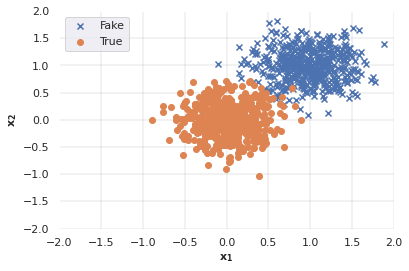

In [ ]:
#visualize the true data
n_samples = 500

COV = [[0.1, 0], [0, 0.1]]
x_data = generate_truncate_normal(mean= [0,0],covariance = COV, n_samples = n_samples)
noise = generate_truncate_normal(mean= [1,1],covariance = COV, n_samples = n_samples)
plt.scatter(noise[:,0],noise[:,1],label = 'Fake',marker = 'x')
plt.scatter(x_data[:,0],x_data[:,1],label = 'True')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.legend()
plt.xlabel(r'$\mathbf{x_1}$', fontsize=11)
plt.ylabel(r'$\mathbf{x_2}$', fontsize=11)
ax = plt.axes()
ax.set_facecolor("white")
ax.grid(True, color = 'black', linewidth = 0.1)
plt.savefig('Gaussian Distribution.pdf', bbox_inches='tight')

In [ ]:
#generate the true data
BUFFER_SIZE = 5000
BATCH_SIZE = 100
n_samples = 10000

COV = [[0.1, 0], [0, 0.1]]
x_data = generate_truncate_normal(mean= [0,0],covariance = COV, n_samples = n_samples)
train_dataset = tf.data.Dataset.from_tensor_slices(x_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

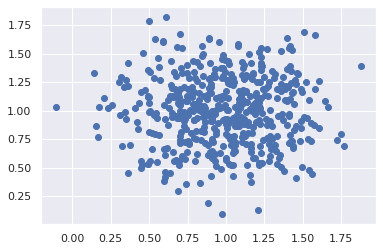

In [ ]:
#generate the fake distribution
noise_1000 = generate_truncate_normal(mean= [1,1],covariance = COV, n_samples = 1000)
plt.scatter(noise[:,0],noise[:,1])

In [ ]:
#define generator
n_g_layers = 20
dt = 0.1
x0 = Input((2))
x = x0
states_G = [x]
for _ in range(n_g_layers):
    x = x + dt * Dense(2, activation='tanh')(x)
    states_G.append(x)
model_generator = tf.keras.Model(x0, x)

In [ ]:
#define discriminator
n_d_layers = 20
dt = 0.1
x1 = Input((2))
x = x1
states_D = [x]
n_d_layers = 20
for _ in range(n_d_layers):
    x = x + dt * Dense(2, activation='tanh')(x)
    states_D.append(x)
last_layer = Dense(1, activation='sigmoid', trainable=False)
y = last_layer(x)
model_discriminator = tf.keras.Model(x1, y)

In [ ]:
#test the untrained discriminator
test_noise = generate_truncate_normal(mean= [1,1],covariance = COV, n_samples = 2)
predict = model_discriminator.predict(test_noise)
print(predict, test_noise)

[[0.27664655]
 [0.27772164]] tf.Tensor(
[[1.0343381 1.0064104]
 [1.1353284 1.2669733]], shape=(2, 2), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
noise_dim = 2
num_examples_to_generate = 10
noise_10 = generate_truncate_normal(COV,10,[1,1])

In [ ]:
def log_generated_probability(generator,test_points = noise_10):
  generated_points = generator.predict(test_points)
  num_examples, dimension  = test_points.shape
  sum = 0
  for i in range(num_examples):
    sum+=generated_points[i].T @ generated_points[i]
  return sum

In [ ]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=model_generator,
                                 discriminator=model_discriminator)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(dataset):
    fake_input = generate_truncate_normal(mean= [1,1],covariance = COV, n_samples = BATCH_SIZE)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_data = model_generator(fake_input, training=True)

      real_output = model_discriminator(dataset, training=True)
      fake_output = model_discriminator(generated_data, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, model_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, model_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, model_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, model_discriminator.trainable_variables))
    return gen_loss,disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input ):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  plt.scatter(predictions[:,0],predictions[:,1])

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  gen_loss = []
  disc_loss = []
  # likelihood = []
  for epoch in range(epochs):
      start = time.time()
      for batch in dataset:
          current_gen_loss, current_disc_loss = train_step(batch)
          gen_loss.append(current_gen_loss)
          disc_loss.append(current_disc_loss)
          # likelihood.append(log_generated_probability(model_generator))
          
      if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        generate_and_save_images(model_generator,epoch + 1,noise_1000)
        plt.clf()
        plt.plot(gen_loss, label = 'Generator Loss')
        plt.plot(disc_loss, label = 'Discriminator Loss')
        plt.legend()
        plt.show()
        # plt.plot(likelihood)
        plt.show()
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  return gen_loss, disc_loss, likelihood

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


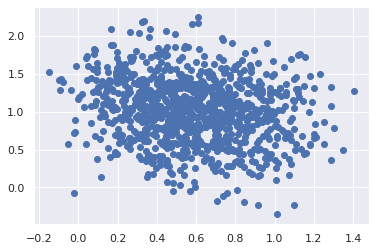

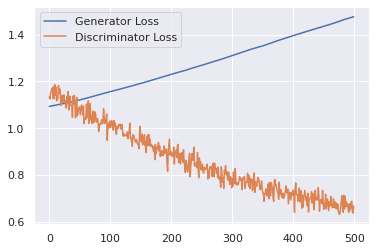

Time for epoch 5 is 1.1368882656097412 sec


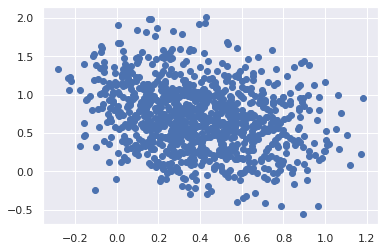

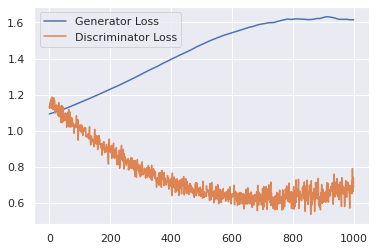

Time for epoch 10 is 1.1680207252502441 sec


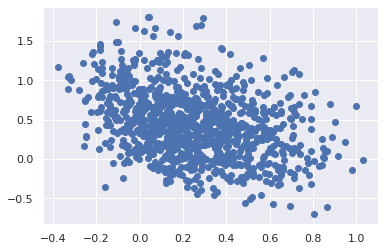

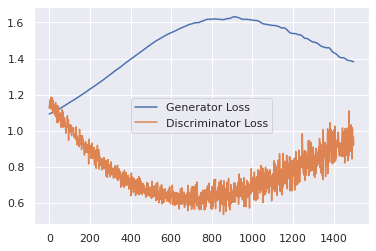

Time for epoch 15 is 1.2316608428955078 sec


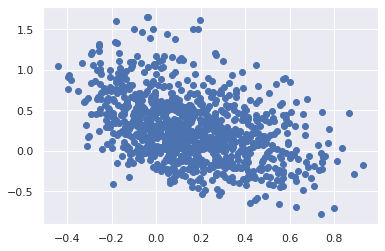

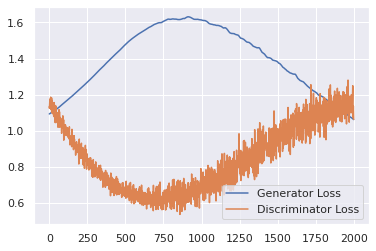

Time for epoch 20 is 1.4150285720825195 sec


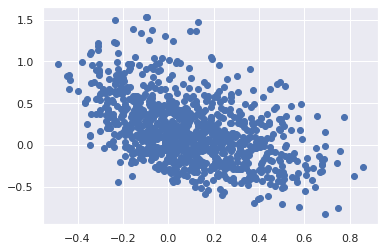

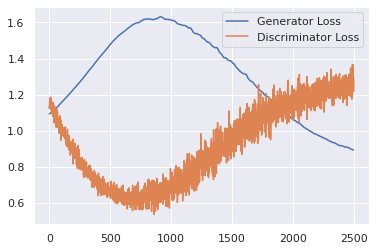

Time for epoch 25 is 1.1092252731323242 sec


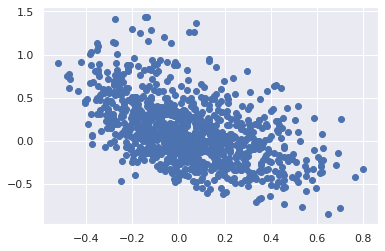

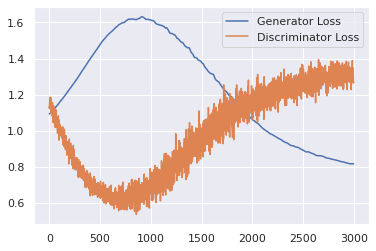

Time for epoch 30 is 1.1981253623962402 sec


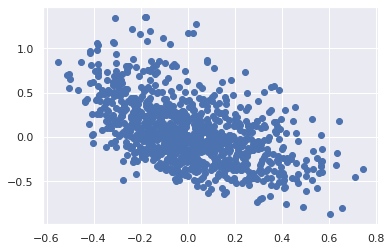

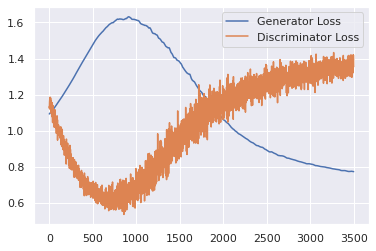

Time for epoch 35 is 1.436661720275879 sec


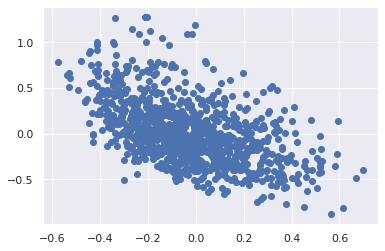

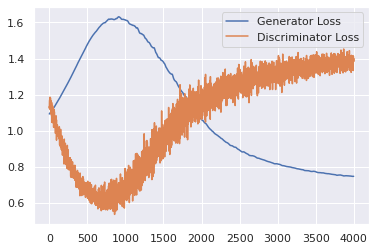

Time for epoch 40 is 1.4398186206817627 sec


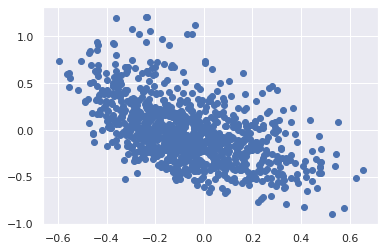

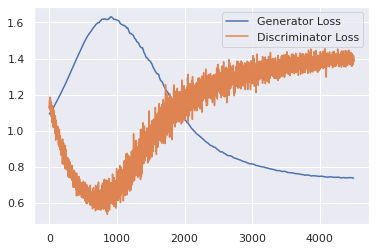

Time for epoch 45 is 1.1405150890350342 sec


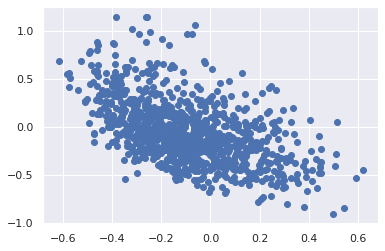

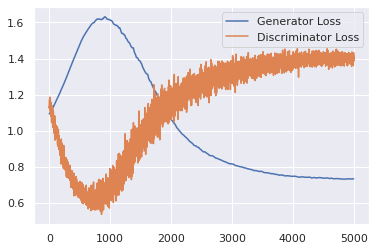

Time for epoch 50 is 1.4352445602416992 sec


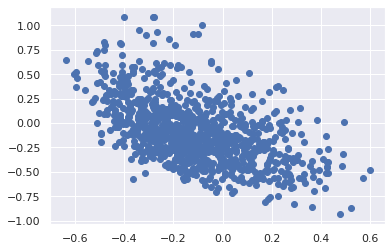

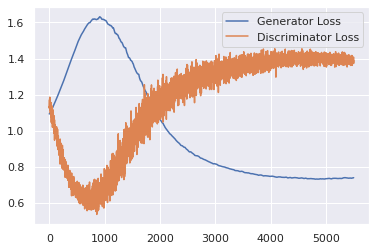

Time for epoch 55 is 1.215421438217163 sec


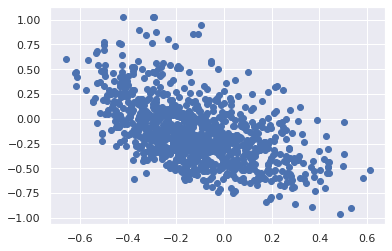

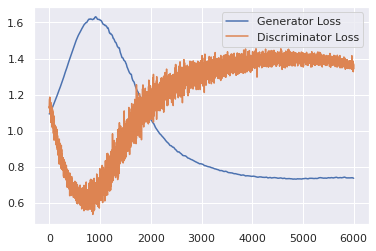

Time for epoch 60 is 1.290330171585083 sec


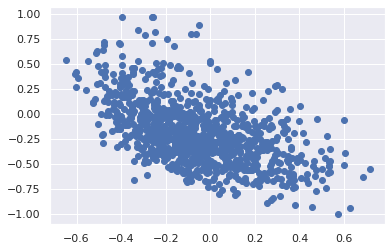

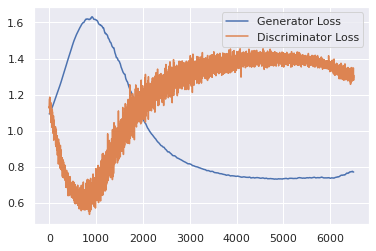

Time for epoch 65 is 1.2234487533569336 sec


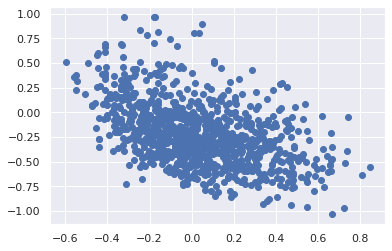

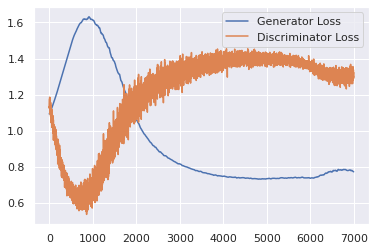

Time for epoch 70 is 1.5118255615234375 sec


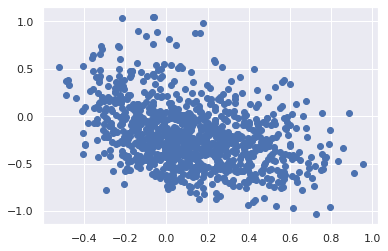

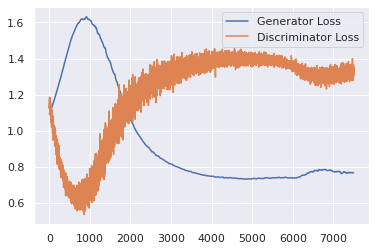

Time for epoch 75 is 1.4909327030181885 sec


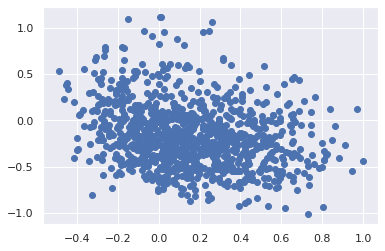

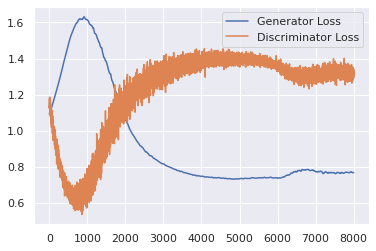

Time for epoch 80 is 1.542623519897461 sec


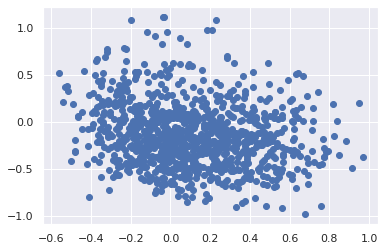

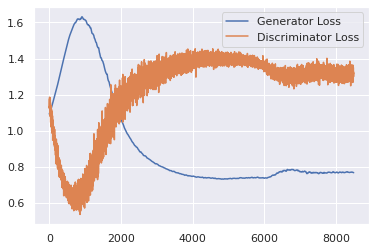

Time for epoch 85 is 1.51003098487854 sec


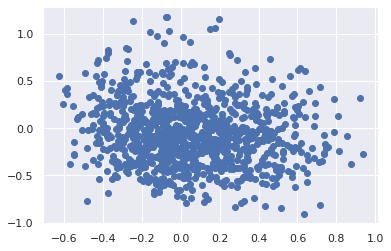

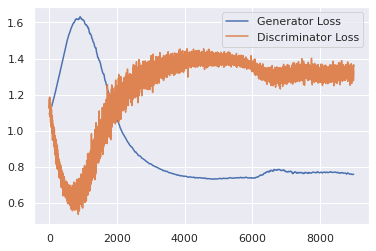

Time for epoch 90 is 1.8204283714294434 sec


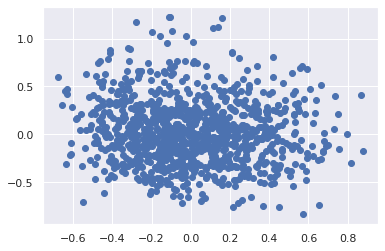

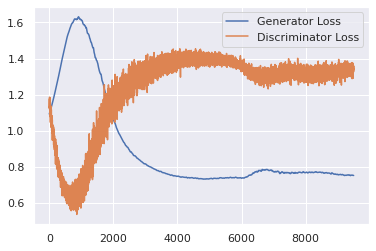

Time for epoch 95 is 1.5582737922668457 sec


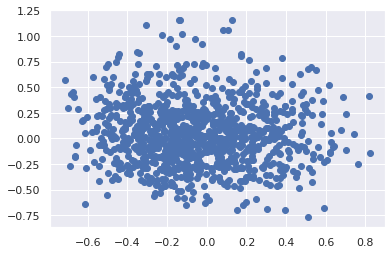

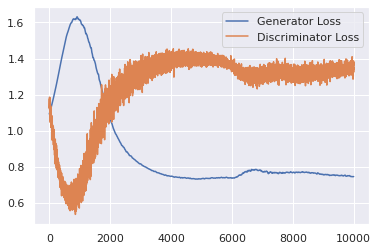

Time for epoch 100 is 1.3439359664916992 sec


In [ ]:
gen_loss, disc_loss, likelihood = train(train_dataset,100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


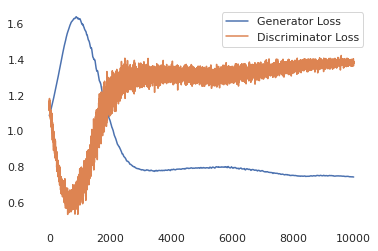

In [ ]:
#Save GAN
f = plt.figure()
plt.plot(gen_loss,label = 'Generator Loss')
plt.plot(disc_loss, label = 'Discriminator Loss')

# set labels (LaTeX can be used)
ax = plt.axes()
ax.set_facecolor("white")
plt.legend('best')
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.grid(False)
plt.show()
# save as PDF
f.savefig("GAN_gau.pdf",bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


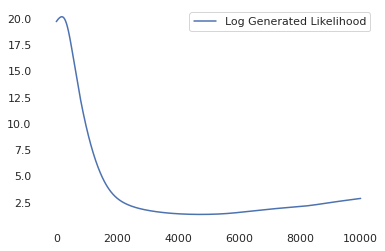

In [ ]:
f = plt.figure()
plt.plot(likelihood,label = 'Log Generated Likelihood')

# set labels (LaTeX can be used)
ax = plt.axes()
ax.set_facecolor("white")
plt.legend('best')
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.grid(False)
plt.show()
# save as PDF
f.savefig("GAN_gau_likeli.pdf",bbox_inches='tight')

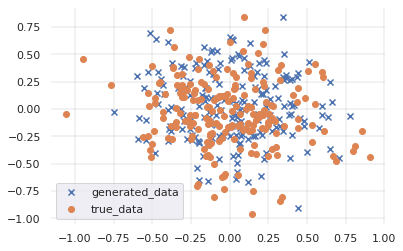

In [ ]:
test_size = 200
true_data = generate_truncate_normal(mean= [0,0],covariance = COV, n_samples = test_size)
noise = generate_truncate_normal(mean= [1,1],covariance = COV, n_samples = test_size)
generated_data = model_generator.predict(noise)
fig, ax = plt.subplots()
ax.scatter(generated_data[:,0],generated_data[:,1],c='C0',marker = 'x', label = 'generated_data')
ax.scatter(true_data[:,0],true_data[:,1], c = 'C1', label = 'true_data')
ax.grid(True, color = 'black', linewidth = 0.1)
ax.set_facecolor("white")
ax.legend()
fig.savefig('comparison.pdf',bbox_inches='tight')

In [ ]:
states_concat = tf.concat([s[:, :, None] for s in states_G], axis=-1)
states_model = tf.keras.Model(x0, states_concat)
states_test = states_model.predict(noise)

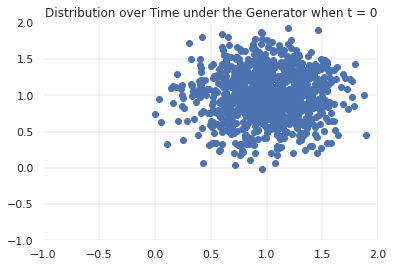

In [ ]:
#GAN_generator video
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML
# Concat and extract all the states
states_concat = tf.concat([s[:, :, None] for s in states_G], axis=-1)
states_model = tf.keras.Model(x0, states_concat)
states_test = states_model.predict(noise_1000)
# Extract the final layer (linear) classifier
# w, b = [w.numpy().squeeze() for w in last_layer.weights]

fig, ax = plt.subplots()

ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)

scat = ax.scatter(
    states_test[:, 0, 0],
    states_test[:, 1, 0],
)

def animate(i):
    scat.set_offsets(states_test[:, :, i])
    ax.set_title('Distribution over Time under the Generator when t = '+str(i))
    ax.grid(True, color = 'black', linewidth = 0.1)
    ax.set_facecolor("white")

    # x1 = np.linspace(-2, 2, 100)
    # x2 = -(1/w[1]) * (w[0] * x1 + b)
    # ax.plot(x1, x2, color='black')
    return (scat,)


anim = FuncAnimation(fig, animate, frames=n_g_layers, interval=200)
writervideo = animation.FFMpegWriter(fps=1.5) 
anim.save('GAN_generator.mp4', writer=writervideo)
HTML(anim.to_html5_video())

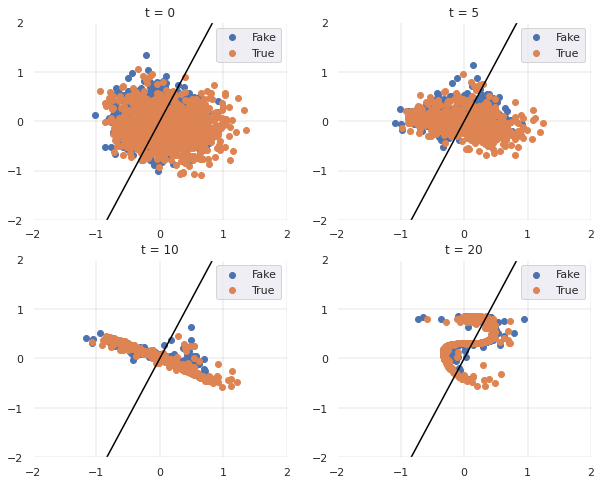

In [ ]:
# GAN_discriminator
# Concat and extract all the states
true_data = generate_truncate_normal(mean= [0,0],covariance = COV, n_samples = 1000)
noise = generate_truncate_normal(mean= [1,1],covariance = COV, n_samples = 1000)
generated_data = model_generator.predict(noise)
y_true = np.ones((1000,1))
y_fake = np.zeros((1000,1))
x_data = tf.concat([true_data,generated_data],axis = 0)
y_data = np.concatenate([y_true,y_fake])


states_concat = tf.concat([s[:, :, None] for s in states_D], axis=-1)
states_model = tf.keras.Model(x1, states_concat)
states_test = states_model.predict(x_data)

# Extract the final layer (linear) classifier
w, b = [w.numpy().squeeze() for w in last_layer.weights]
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(2,2,figsize = (10,8))
custom_xlim = (-2, 2)
custom_ylim = (-2, 2)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
# fig.suptitle('Distribution of Points through the Process of Discriminator',fontweight ="bold")

def draw(i,ax):
  ax.scatter(
    states_test[:1000, 0, i],
    states_test[:1000, 1, i],
    c='C0',
    label = 'Fake'
    )
  ax.scatter(
    states_test[1000:, 0, i],
    states_test[1000:, 1, i],
    c='C1',
    label = 'True'
    )
  x1 = np.linspace(-2, 2, 100)
  x2 = -(1/w[1]) * (w[0] * x1 + b)
  ax.plot(x1, x2, color='black')
  ax.grid(True, color = 'black', linewidth = 0.1)
  ax.set_facecolor("white")
  ax.set_title("t = "+str(i))
  ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.yaxis.set_major_locator(MultipleLocator(1))
  ax.legend()

draw(0,ax[0,0])
draw(5,ax[0,1])
draw(10,ax[1,0])
draw(20,ax[1,1])
fig.savefig("Evo_5.pdf",bbox_inches='tight')

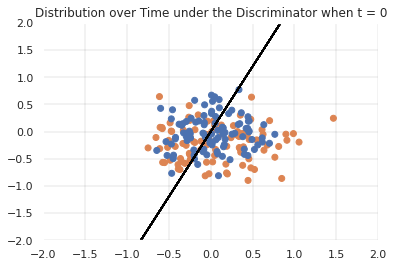

In [ ]:
#GAN_Discriminator video
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML
# Concat and extract all the states

test_size = 100
true_data = generate_truncate_normal(mean= [0,0],covariance = COV, n_samples = test_size)
noise = generate_truncate_normal(mean= [1,1],covariance = COV, n_samples = test_size)
y_true = np.ones((test_size,1))
y_fake = np.zeros((test_size,1))
generated_data = model_generator.predict(noise)
x_data = tf.concat([generated_data,true_data],axis = 0)
y_data = np.concatenate([y_true,y_fake])


states_concat = tf.concat([s[:, :, None] for s in states_D], axis=-1)
states_model = tf.keras.Model(x1, states_concat)
states_test = states_model.predict(x_data)

# Extract the final layer (linear) classifier
w, b = [w.numpy().squeeze() for w in last_layer.weights]

fig, ax = plt.subplots()

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)


scat = ax.scatter(
    states_test[:, 0, 0],
    states_test[:, 1, 0],
    c=['C0' if y==0 else 'C1' for y in y_data],
)



def animate(i):
    scat.set_offsets(states_test[:, :, i])
    x1 = np.linspace(-2, 2, 100)
    x2 = -(1/w[1]) * (w[0] * x1 + b)
    ax.plot(x1, x2, color='black')
    ax.set_title('Distribution over Time under the Discriminator when t = '+str(i))
    ax.grid(True, color = 'black', linewidth = 0.1)
    ax.set_facecolor("white")
    return (scat,)


anim = FuncAnimation(fig, animate, frames=n_g_layers, interval=200)
writervideo = animation.FFMpegWriter(fps=2) 
anim.save('GAN_Discriminator.mp4', writer=writervideo)
HTML(anim.to_html5_video())

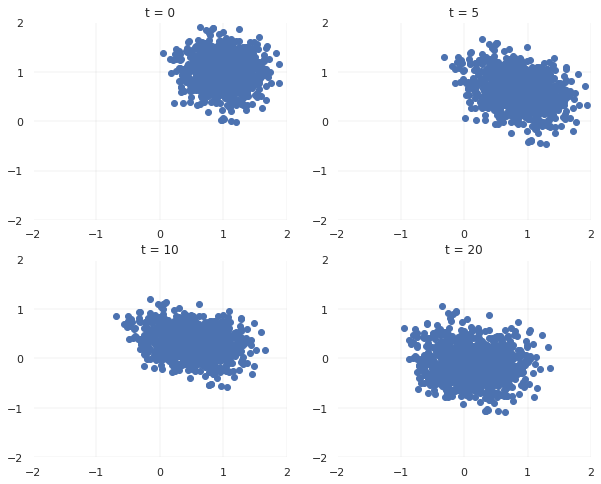

In [ ]:
#GAN_GEN
# Concat and extract all the states
states_concat = tf.concat([s[:, :, None] for s in states_G], axis=-1)
states_model = tf.keras.Model(x0, states_concat)
states_test = states_model.predict(noise)

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(2,2,figsize = (10,8))
custom_xlim = (-2, 2)
custom_ylim = (-2, 2)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)


def draw(i,ax):
  ax.scatter(
    states_test[:, 0, i],
    states_test[:, 1, i],
  )
  ax.grid(True, alpha = 0.5, color = 'black', linewidth = 0.1)
  ax.set_facecolor("white")
  ax.set_title("t = "+str(i))
  ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.yaxis.set_major_locator(MultipleLocator(1))

draw(0,ax[0,0])
draw(5,ax[0,1])
draw(10,ax[1,0])
draw(20,ax[1,1])
fig.savefig("Evo_6.pdf",bbox_inches='tight')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# #define dummy discriminator
# x1 = Input((2))
# y = Dense(1, activation='sigmoid', trainable=False)(x)
# model_discriminator = tf.keras.Model(x, y)
# a = np.array([[0],[-1]])
# b = np.array([0.5])
# c = [a,b]
# print(c)
# model_discriminator.layers[1].set_weights(c)

In [ ]:
# #define dummy generator
# x0 = Input((2))
# model_generator = tf.keras.Model(x0, x0)

In [ ]:
# def generate_truncate_normal(covariance, n_samples, mean, amin=0, amax=1, bmin=0, bmax=1):
#   x_data = np.zeros((0, 2),dtype='float32')   # 2 columns now
#   while x_data.shape[0] < n_samples: 
#       s = np.random.multivariate_normal(mean, cov, size=(n_samples,))
#       accepted = s[(np.min(s - [amin, bmin], axis=1) >= 0) & (np.max(s - [amax, bmax], axis=1) <= 0)]
#       x_data = np.concatenate((x_data, accepted), axis=0)
#   x_data = x_data[:n_samples, :]
#   return tf.convert_to_tensor(x_data,dtype = np.float32)

(0.0, 1.0)

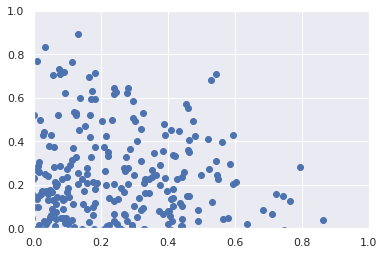

In [ ]:
# #target distribution
# noise = generate_truncate_normal(mean= [0,0],covariance = COV, n_samples = 1000)
# plt.scatter(noise[:,0],noise[:,1])
# plt.xlim(0,1)
# plt.ylim(0,1)